In [1]:
import pandas as pd

user_visit_data = pd.read_csv("user_visit_data.csv")
app_event_data = pd.read_csv("app_event_data.csv")

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

In [3]:
user_visit_data.head()

,log_date,user_id,country,created
0,20230429,11528,MY,20230427
1,20230429,11241,MY,20230425
2,20230429,11654,MY,20230429
3,20230429,11309,PH,20230425
4,20230429,10057,PH,20230407


In [4]:
app_event_data.head()

,user_id,app_version,event_name,event_date,event_timestamp,params
0,10311,1.0.06,GUIDE_MISSION_PASS,20230502,1683050525,"[{key=best_stage, value=71}, {key=current_guid..."
1,10311,1.0.06,GUIDE_MISSION_PASS,20230502,1683050523,"[{key=best_stage, value=71}, {key=current_guid..."
2,11467,1.0.06,GUIDE_MISSION_PASS,20230502,1683052803,"[{key=best_stage, value=76}, {key=current_guid..."
3,11516,1.0.06,GUIDE_MISSION_PASS,20230502,1683051453,"[{key=best_stage, value=67}, {key=current_guid..."
4,11516,1.0.06,GUIDE_MISSION_PASS,20230502,1683051452,"[{key=best_stage, value=67}, {key=current_guid..."


In [5]:
user_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   log_date  17520 non-null  int64 
 1   user_id   17520 non-null  int64 
 2   country   17520 non-null  object
 3   created   17520 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 547.6+ KB


In [6]:
app_event_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894301 entries, 0 to 894300
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   user_id          894301 non-null  int64 
 1   app_version      894301 non-null  object
 2   event_name       894301 non-null  object
 3   event_date       894301 non-null  int64 
 4   event_timestamp  894301 non-null  int64 
 5   params           894301 non-null  object
dtypes: int64(3), object(3)
memory usage: 40.9+ MB


In [7]:
launch_1_start = 20230420
launch_1_end = 20230428

launch_2_start = 20230603
launch_2_end = 20230612

launch_1 = user_visit_data[
    (user_visit_data['created'] >= launch_1_start) & 
    (user_visit_data['created'] <= launch_1_end)
]

launch_2 = user_visit_data[
    (user_visit_data['created'] >= launch_2_start) & 
    (user_visit_data['created'] <= launch_2_end)
]

new_users_1 = launch_1['user_id'].nunique()
new_users_2 = launch_2['user_id'].nunique()

print(f"1차 런칭 신규 가입자: {new_users_1}")
print(f"2차 런칭 신규 가입자: {new_users_2}")

1차 런칭 신규 가입자: 1211
2차 런칭 신규 가입자: 3638


In [8]:
import re

#  파라미터 문자열을 key-value 딕셔너리로 파싱하는 함수 정의
def parse_param_string(param_str):
    if pd.isna(param_str):
        return {}

    # 정규식 패턴: {key=..., value=...}
    pattern = r'\{key=([^,]+),\s*value=([^}]+)\}'
    matches = re.findall(pattern, param_str)
    
    result = {}
    for key, value in matches:
        key = key.strip()
        value = value.strip()

        #  가능하면 숫자형으로 변환 (세미콜론이 있다면 첫 번째 값만 사용)
        value = value.split(";")[0]  
        try:
            numeric_value = float(value) if "." in value else int(value)
        except ValueError:
            # 🚨 "pass" → 1, "fail" → 0 변환
            numeric_value = 1 if value.lower() == "pass" else 0 if value.lower() == "fail" else 0  
        
        result[key] = numeric_value
    return result

#  params 컬럼을 파싱하여 새로운 딕셔너리 컬럼 생성
app_event_data['params_parsed'] = app_event_data['params'].apply(parse_param_string)

#  딕셔너리 컬럼을 개별 컬럼으로 확장
params_df = pd.json_normalize(app_event_data['params_parsed'])

#  **필요한 컬럼만 필터링** (전투력 비교, 과금 패턴, 유저 행동 변화)
target_columns = [
    "user_power", "stage_power", "result",  # 전투력 비교
    "pay_amount", "pay_count", "current_hard_currency", "since_join_date",  # 과금 패턴
    "total_play_time", "total_session_count", "daily_visit_count", "user_character_collection", "user_level"  # 유저 행동
]
params_df_filtered = params_df[target_columns]

#  원본 데이터에서 필요없는 컬럼 제거 후 결합
app_event_data_expanded = pd.concat([app_event_data.drop(columns=['params_parsed', 'params']), params_df_filtered], axis=1)

#  결과 확인
app_event_data_expanded.head()


,user_id,app_version,event_name,event_date,event_timestamp,user_power,stage_power,result,pay_amount,pay_count,current_hard_currency,since_join_date,total_play_time,total_session_count,daily_visit_count,user_character_collection,user_level
0,10311,1.0.06,GUIDE_MISSION_PASS,20230502,1683050525,508159516,NaN,NaN,0.0,0,18630,23,206,12,7,22,128
1,10311,1.0.06,GUIDE_MISSION_PASS,20230502,1683050523,508159516,NaN,NaN,0.0,0,18530,23,205,12,7,22,128
2,11467,1.0.06,GUIDE_MISSION_PASS,20230502,1683052803,903769976,NaN,NaN,0.0,0,1110,5,184,38,6,29,144
3,11516,1.0.06,GUIDE_MISSION_PASS,20230502,1683051453,194956458,NaN,NaN,0.0,0,7140,5,271,28,6,23,139
4,11516,1.0.06,GUIDE_MISSION_PASS,20230502,1683051452,194956458,NaN,NaN,0.0,0,7040,5,271,28,6,23,139


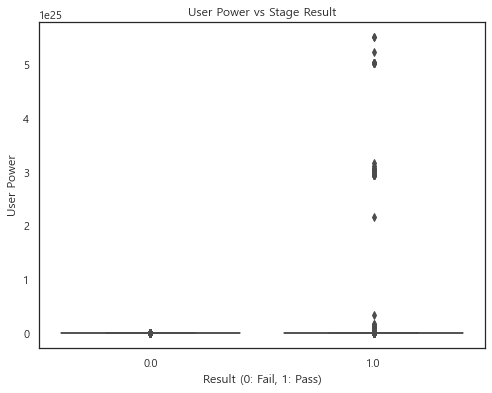

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=app_event_data_expanded["result"], y=app_event_data_expanded["user_power"])
plt.xlabel("Result (0: Fail, 1: Pass)")
plt.ylabel("User Power")
plt.title("User Power vs Stage Result")
plt.show()

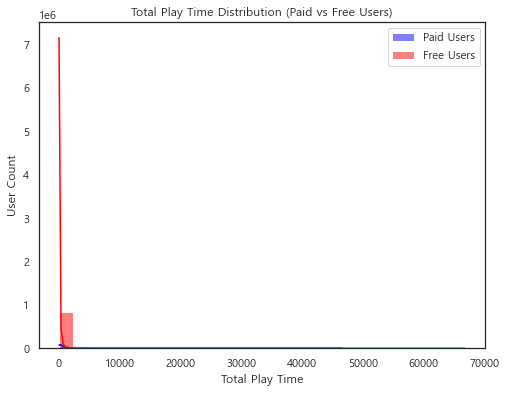

In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(app_event_data_expanded[app_event_data_expanded["pay_amount"] > 0]["total_play_time"], bins=30, color='blue', label="Paid Users", kde=True)
sns.histplot(app_event_data_expanded[app_event_data_expanded["pay_amount"] == 0]["total_play_time"], bins=30, color='red', label="Free Users", kde=True)
plt.xlabel("Total Play Time")
plt.ylabel("User Count")
plt.title("Total Play Time Distribution (Paid vs Free Users)")
plt.legend()
plt.show()

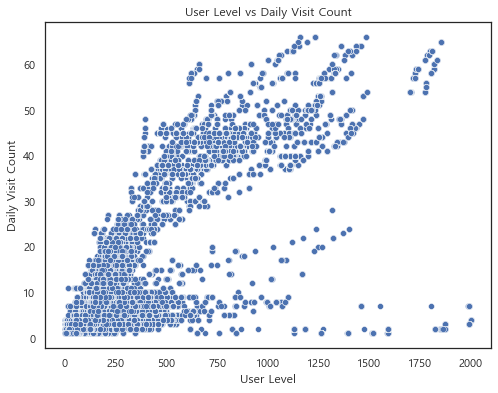

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=app_event_data_expanded["user_level"], y=app_event_data_expanded["daily_visit_count"])
plt.xlabel("User Level")
plt.ylabel("Daily Visit Count")
plt.title("User Level vs Daily Visit Count")
plt.show()

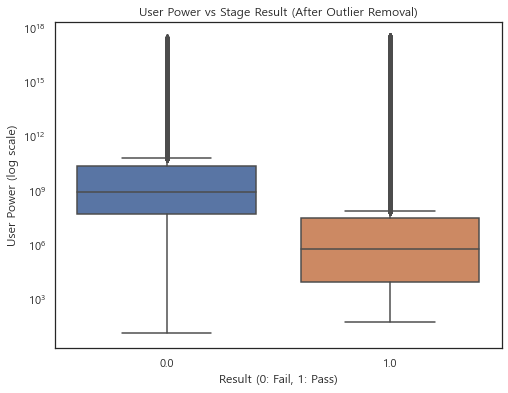

In [12]:
import numpy as np


df_filtered = app_event_data_expanded[app_event_data_expanded['user_power'] < app_event_data_expanded['user_power'].quantile(0.99)]

plt.figure(figsize=(8,6))
sns.boxplot(x=df_filtered['result'], y=df_filtered['user_power'])
plt.yscale('log')  
plt.xlabel('Result (0: Fail, 1: Pass)')
plt.ylabel('User Power (log scale)')
plt.title('User Power vs Stage Result (After Outlier Removal)')
plt.show()

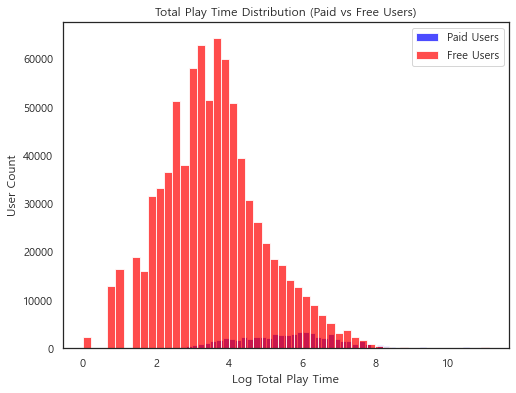

In [13]:
app_event_data_expanded['log_total_play_time'] = np.log1p(app_event_data_expanded['total_play_time'])  # log(1 + x) 변환

plt.figure(figsize=(8,6))
sns.histplot(app_event_data_expanded[app_event_data_expanded['pay_amount'] > 0]['log_total_play_time'], bins=50, color='blue', label='Paid Users', alpha=0.7)
sns.histplot(app_event_data_expanded[app_event_data_expanded['pay_amount'] == 0]['log_total_play_time'], bins=50, color='red', label='Free Users', alpha=0.7)
plt.xlabel('Log Total Play Time')
plt.ylabel('User Count')
plt.title('Total Play Time Distribution (Paid vs Free Users)')
plt.legend()
plt.show()

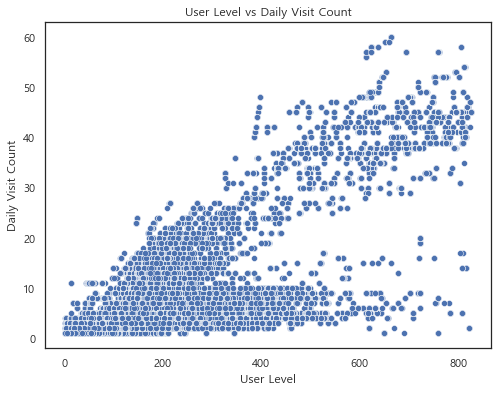

In [14]:
df_filtered = app_event_data_expanded[app_event_data_expanded['user_level'] < app_event_data_expanded['user_level'].quantile(0.99)]

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_filtered['user_level'], y=df_filtered['daily_visit_count'])
plt.xlabel('User Level')
plt.ylabel('Daily Visit Count')
plt.title('User Level vs Daily Visit Count')
plt.show()

In [15]:
print(app_event_data_expanded.columns)

Index(['user_id', 'app_version', 'event_name', 'event_date', 'event_timestamp',
       'user_power', 'stage_power', 'result', 'pay_amount', 'pay_count',
       'current_hard_currency', 'since_join_date', 'total_play_time',
       'total_session_count', 'daily_visit_count', 'user_character_collection',
       'user_level', 'log_total_play_time'],
      dtype='object')


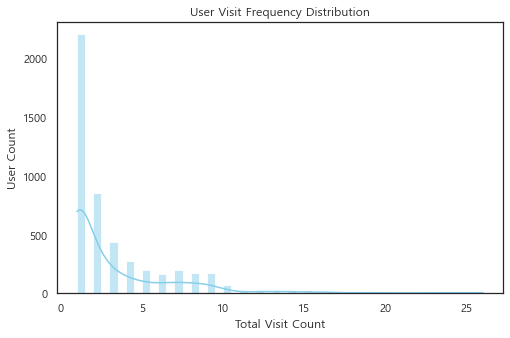

In [16]:
visit_counts = user_visit_data.groupby('user_id')['log_date'].count().reset_index()
visit_counts.columns = ['user_id', 'visit_count']

plt.figure(figsize=(8, 5))
sns.histplot(visit_counts['visit_count'], bins=50, kde=True, color='skyblue')
plt.xlabel('Total Visit Count')
plt.ylabel('User Count')
plt.title('User Visit Frequency Distribution')
plt.show()

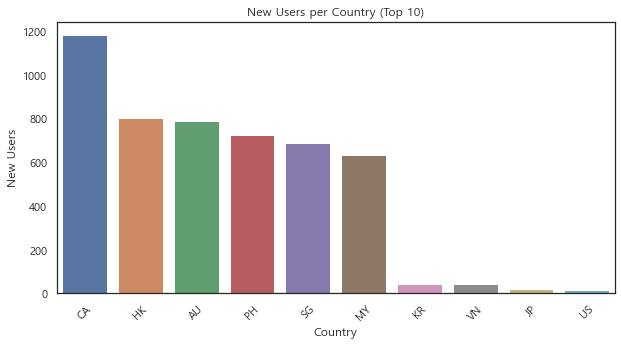

In [17]:
country_new_users = user_visit_data.groupby('country')['user_id'].nunique().reset_index()
country_new_users.columns = ['country', 'new_user_count']

plt.figure(figsize=(10, 5))
sns.barplot(data=country_new_users.sort_values(by='new_user_count', ascending=False)[:10], x='country', y='new_user_count')
plt.xlabel('Country')
plt.ylabel('New Users')
plt.title('New Users per Country (Top 10)')
plt.xticks(rotation=45)
plt.show()

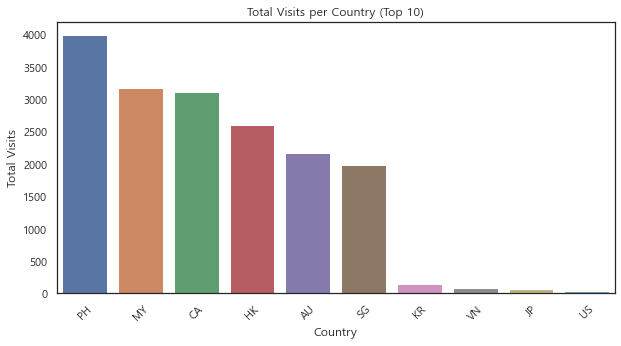

In [18]:
country_visit_counts = user_visit_data.groupby('country')['log_date'].count().reset_index()
country_visit_counts.columns = ['country', 'total_visits']

plt.figure(figsize=(10, 5))
sns.barplot(data=country_visit_counts.sort_values(by='total_visits', ascending=False)[:10], x='country', y='total_visits')
plt.xlabel('Country')
plt.ylabel('Total Visits')
plt.title('Total Visits per Country (Top 10)')
plt.xticks(rotation=45)
plt.show()

In [19]:
first_launch_users = user_visit_data[(user_visit_data["created"] >= 20230420) & (user_visit_data["created"] <= 20230428)]
second_launch_users = user_visit_data[(user_visit_data["created"] >= 20230603) & (user_visit_data["created"] <= 20230612)]

first_user_ids = set(first_launch_users["user_id"])
second_user_ids = set(second_launch_users["user_id"])

first_launch_visits = user_visit_data[user_visit_data["user_id"].isin(first_user_ids)]
second_launch_visits = user_visit_data[user_visit_data["user_id"].isin(second_user_ids)]

In [20]:
first_total_visits = first_launch_visits.shape[0]
second_total_visits = second_launch_visits.shape[0]

print(f"1차 총 방문 횟수: {first_total_visits}")
print(f"2차 총 방문 횟수: {second_total_visits}")

1차 총 방문 횟수: 5990
2차 총 방문 횟수: 10287


In [21]:
first_avg_visits = first_launch_visits.groupby("user_id")["log_date"].count().mean()
second_avg_visits = second_launch_visits.groupby("user_id")["log_date"].count().mean()

print(f"1차 평균 방문 횟수: {first_avg_visits:.2f}")
print(f"2차 평균 방문 횟수: {second_avg_visits:.2f}")

1차 평균 방문 횟수: 4.95
2차 평균 방문 횟수: 2.83


In [32]:
first_d1_users = first_launch_visits[first_launch_visits.apply(lambda row: row["log_date"] == row["created"] + 1, axis=1)]["user_id"].nunique()
second_d1_users = second_launch_visits[second_launch_visits.apply(lambda row: row["log_date"] == row["created"] + 1, axis=1)]["user_id"].nunique()

first_d1_retention = (first_d1_users / len(first_user_ids)) * 100
second_d1_retention = (second_d1_users / len(second_user_ids)) * 100

print(f"1차 D1 유지율: {first_d1_retention:.2f}%")
print(f"2차 D1 유지율: {second_d1_retention:.2f}%")

1차 D1 유지율: 54.91%
2차 D1 유지율: 48.60%


In [33]:
first_d7_users = first_launch_visits[first_launch_visits.apply(lambda row: row["log_date"] == row["created"] + 7, axis=1)]["user_id"].nunique()
second_d7_users = second_launch_visits[second_launch_visits.apply(lambda row: row["log_date"] == row["created"] + 7, axis=1)]["user_id"].nunique()

first_d7_retention = (first_d7_users / len(first_user_ids)) * 100
second_d7_retention = (second_d7_users / len(second_user_ids)) * 100

print(f"1차 D7 유지율: {first_d7_retention:.2f}%")
print(f"2차 D7 유지율: {second_d7_retention:.2f}%")


1차 D7 유지율: 15.19%
2차 D7 유지율: 11.19%


In [35]:
comparison_data = {
    "지표": ["총 방문 횟수", "평균 방문 횟수", "D1 유지율", "D7 유지율"],
    "1차 런칭": [first_total_visits, first_avg_visits, first_d1_retention, first_d7_retention],
    "2차 런칭": [second_total_visits, second_avg_visits, second_d1_retention, second_d7_retention]
}

df_comparison = pd.DataFrame(comparison_data)

In [26]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

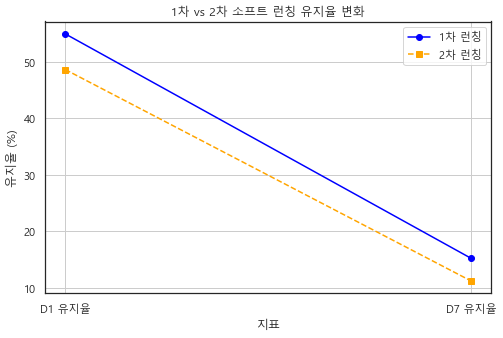

In [36]:
df_retention = df_comparison[df_comparison["지표"].str.contains("유지율")]

plt.figure(figsize=(8, 5))
plt.plot(df_retention["지표"], df_retention["1차 런칭"], marker="o", linestyle="-", label="1차 런칭", color="blue")
plt.plot(df_retention["지표"], df_retention["2차 런칭"], marker="s", linestyle="--", label="2차 런칭", color="orange")

plt.title("1차 vs 2차 소프트 런칭 유지율 변화")
plt.ylabel("유지율 (%)")
plt.xlabel("지표")
plt.legend()
plt.grid(True)
plt.show()

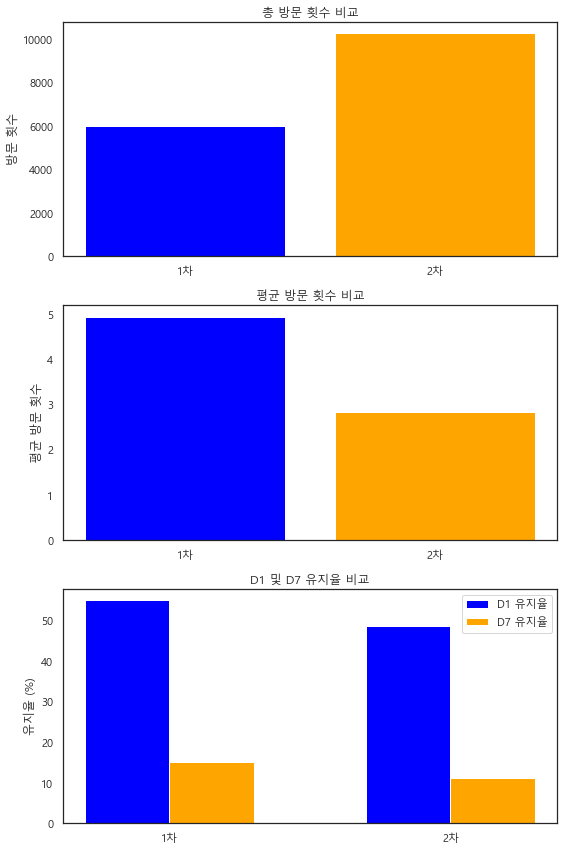

In [28]:
categories = ["1차", "2차"]
total_visits = [5990, 10287]
avg_visits = [4.95, 2.83]
d1_retention = [54.91, 48.60]
d7_retention = [15.19, 11.19]

x = np.arange(len(categories))  # x축 좌표

fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].bar(categories, total_visits, color=['blue', 'orange'])
axs[0].set_title("총 방문 횟수 비교")
axs[0].set_ylabel("방문 횟수")

axs[1].bar(categories, avg_visits, color=['blue', 'orange'])
axs[1].set_title("평균 방문 횟수 비교")
axs[1].set_ylabel("평균 방문 횟수")

width = 0.3
axs[2].bar(x - width/2, d1_retention, width, label="D1 유지율", color='blue')
axs[2].bar(x + width/2, d7_retention, width, label="D7 유지율", color='orange')
axs[2].set_title("D1 및 D7 유지율 비교")
axs[2].set_ylabel("유지율 (%)")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categories)
axs[2].legend()

plt.tight_layout()
plt.show()

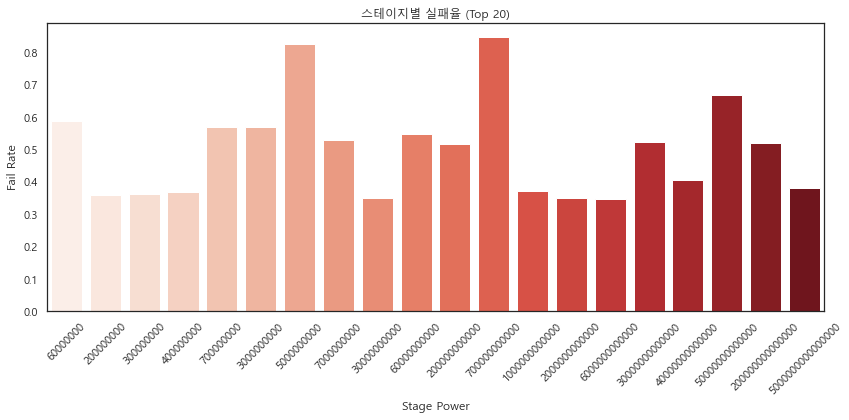

In [38]:
stage_fail_rate = (
    app_event_data_expanded.dropna(subset=['stage_power'])  # 의미 있는 스테이지만
    .groupby('stage_power')['result']
    .apply(lambda x: (x == 0).sum() / len(x))  # 0 = 실패
    .reset_index(name='fail_rate')
)

plt.figure(figsize=(12, 6))
sns.barplot(data=stage_fail_rate.sort_values(by="fail_rate", ascending=False).head(20),
            x="stage_power", y="fail_rate", palette="Reds")
plt.xticks(rotation=45)
plt.title("스테이지별 실패율 (Top 20)")
plt.xlabel("Stage Power")
plt.ylabel("Fail Rate")
plt.tight_layout()
plt.show()


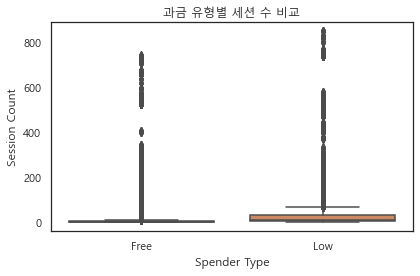

In [39]:
def label_spender(row):
    if row["pay_amount"] == 0:
        return "Free"
    elif row["pay_amount"] < 10000:
        return "Low"
    elif row["pay_amount"] < 100000:
        return "Mid"
    else:
        return "High"

app_event_data_expanded["spender_type"] = app_event_data_expanded.apply(label_spender, axis=1)

sns.boxplot(x="spender_type", y="total_session_count", data=app_event_data_expanded)
plt.title("과금 유형별 세션 수 비교")
plt.xlabel("Spender Type")
plt.ylabel("Session Count")
plt.tight_layout()
plt.show()
